# 0. Load and prepare data 

In [8]:
# test
import numpy as np
np.random.seed(123123)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# Load csv file with pandas
df = pd.read_csv('data/diabetes.csv')

# drop all na values
df = df.dropna()


# X and y
X = df.drop('Outcome', axis=1).values  # shape: (n_samples, 8)
y = df['Outcome'].values.reshape(-1, 1)  # shape: (n_samples, 1)

# basic Scaling 
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123123)


print(X_train.shape)  # (614, 8)
print(y_train.shape)  # (614, 1)

(537, 8)
(537, 1)


# 1. Own Implementation

In [ ]:
# imports

#from scipy.special import expit  # Sigmoid

In [9]:
# import NeuralNetwork from Implementation/NeuralNetwork.py
from Implementation.NeuralNetwork import NeuralNetwork  


## Train the Network 


=== Training Model 1/14 ===
Parameters: {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16, 'output_size': 1, 'lr': 0.05, 'activation_hidden': 'sigmoid', 'l2_lambda': 0.0}
Epoch 0: Loss = 0.687785 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.642976 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.464809 | Train Acc = 0.7709 | Test Acc = 0.7706
Epoch 30000: Loss = 0.456820 | Train Acc = 0.7709 | Test Acc = 0.7662
Epoch 40000: Loss = 0.440959 | Train Acc = 0.7896 | Test Acc = 0.7879
Epoch 50000: Loss = 0.416592 | Train Acc = 0.7952 | Test Acc = 0.7749
Epoch 60000: Loss = 0.390700 | Train Acc = 0.8101 | Test Acc = 0.7749
Epoch 70000: Loss = 0.344339 | Train Acc = 0.8454 | Test Acc = 0.7922
Epoch 80000: Loss = 0.265734 | Train Acc = 0.8752 | Test Acc = 0.7619
Epoch 90000: Loss = 0.174412 | Train Acc = 0.9385 | Test Acc = 0.7403
Epoch 100000: Loss = 0.092939 | Train Acc = 0.9777 | Test Acc = 0.7229
Epoch 110000: Loss = 0.049148 | Train Acc = 0.9963 | T

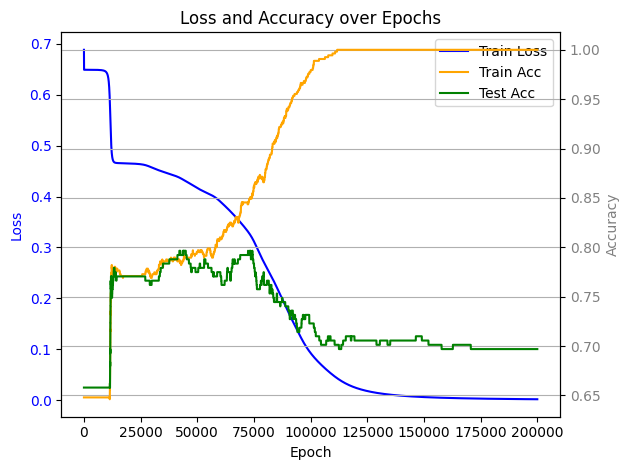


Minimum loss: 0.002290
Maximum train accuracy: 1.0000
Maximum test accuracy: 0.7965

=== Training Model 2/14 ===
Parameters: {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16, 'output_size': 1, 'lr': 0.05, 'activation_hidden': 'sigmoid', 'l2_lambda': 0.001}
Epoch 0: Loss = 0.694983 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.648108 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.465999 | Train Acc = 0.7765 | Test Acc = 0.7706
Epoch 30000: Loss = 0.465429 | Train Acc = 0.7765 | Test Acc = 0.7706
Epoch 40000: Loss = 0.463929 | Train Acc = 0.7803 | Test Acc = 0.7619
Epoch 50000: Loss = 0.460645 | Train Acc = 0.7803 | Test Acc = 0.7706
Epoch 60000: Loss = 0.451372 | Train Acc = 0.7803 | Test Acc = 0.7792
Epoch 70000: Loss = 0.440727 | Train Acc = 0.7877 | Test Acc = 0.7835
Epoch 80000: Loss = 0.430449 | Train Acc = 0.7877 | Test Acc = 0.7965
Epoch 90000: Loss = 0.422076 | Train Acc = 0.7914 | Test Acc = 0.7879
Epoch 100000: Loss = 0.414628 | Train 

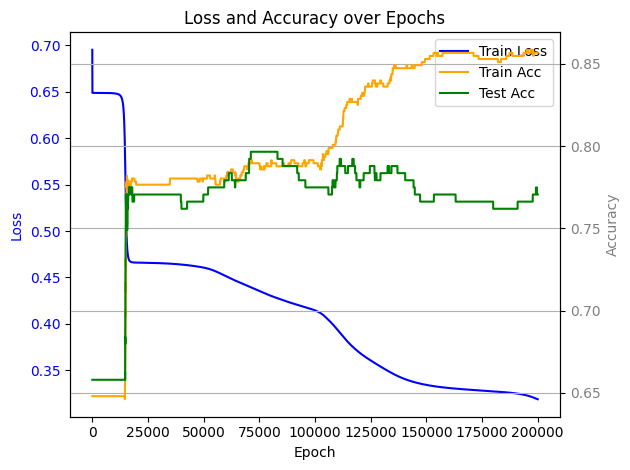


Minimum loss: 0.318973
Maximum train accuracy: 0.8585
Maximum test accuracy: 0.7965

=== Training Model 3/14 ===
Parameters: {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16, 'output_size': 1, 'lr': 0.05, 'activation_hidden': 'sigmoid', 'l2_lambda': 0.003}
Epoch 0: Loss = 0.692830 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.648623 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.648613 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 30000: Loss = 0.648618 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 40000: Loss = 0.648630 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 50000: Loss = 0.648642 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 60000: Loss = 0.648647 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 70000: Loss = 0.648648 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 80000: Loss = 0.648649 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 90000: Loss = 0.648649 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 100000: Loss = 0.648649 | Train 

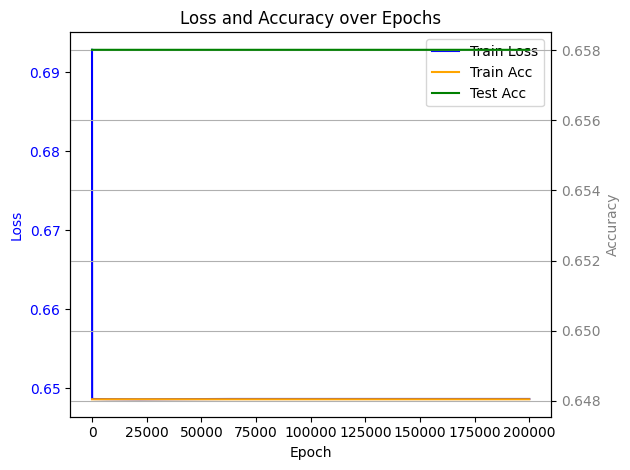


Minimum loss: 0.648613
Maximum train accuracy: 0.6480
Maximum test accuracy: 0.6580

=== Training Model 4/14 ===
Parameters: {'input_size': 8, 'hidden1_size': 4, 'hidden2_size': 2, 'output_size': 1, 'lr': 0.05, 'activation_hidden': 'sigmoid', 'l2_lambda': 0.0}
Epoch 0: Loss = 0.693805 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.648409 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.467159 | Train Acc = 0.7728 | Test Acc = 0.7619
Epoch 30000: Loss = 0.437972 | Train Acc = 0.7747 | Test Acc = 0.7879
Epoch 40000: Loss = 0.415951 | Train Acc = 0.7858 | Test Acc = 0.7792
Epoch 50000: Loss = 0.401378 | Train Acc = 0.8101 | Test Acc = 0.7576
Epoch 60000: Loss = 0.381981 | Train Acc = 0.8268 | Test Acc = 0.7532
Epoch 70000: Loss = 0.372456 | Train Acc = 0.8268 | Test Acc = 0.7576
Epoch 80000: Loss = 0.368297 | Train Acc = 0.8324 | Test Acc = 0.7662
Epoch 90000: Loss = 0.365788 | Train Acc = 0.8305 | Test Acc = 0.7662
Epoch 100000: Loss = 0.364014 | Train Acc 

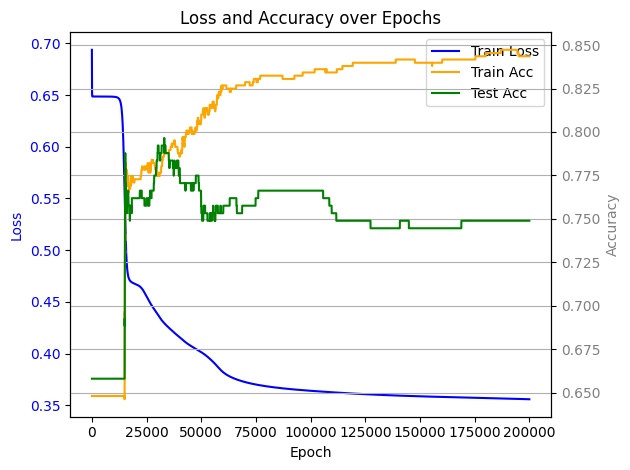


Minimum loss: 0.355834
Maximum train accuracy: 0.8473
Maximum test accuracy: 0.7965

=== Training Model 5/14 ===
Parameters: {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.05, 'activation_hidden': 'sigmoid', 'l2_lambda': 0.0}
Epoch 0: Loss = 0.695517 | Train Acc = 0.3520 | Test Acc = 0.3420
Epoch 10000: Loss = 0.648320 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.464050 | Train Acc = 0.7728 | Test Acc = 0.7662
Epoch 30000: Loss = 0.437302 | Train Acc = 0.7840 | Test Acc = 0.7965
Epoch 40000: Loss = 0.419114 | Train Acc = 0.7840 | Test Acc = 0.7619
Epoch 50000: Loss = 0.395442 | Train Acc = 0.8045 | Test Acc = 0.7576
Epoch 60000: Loss = 0.373962 | Train Acc = 0.8250 | Test Acc = 0.7662
Epoch 70000: Loss = 0.356234 | Train Acc = 0.8268 | Test Acc = 0.7576
Epoch 80000: Loss = 0.351292 | Train Acc = 0.8343 | Test Acc = 0.7619
Epoch 90000: Loss = 0.347256 | Train Acc = 0.8417 | Test Acc = 0.7489
Epoch 100000: Loss = 0.341650 | Train Acc 

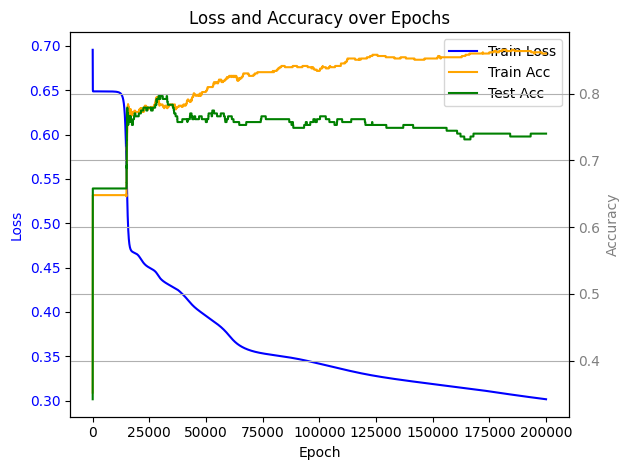


Minimum loss: 0.301565
Maximum train accuracy: 0.8659
Maximum test accuracy: 0.7965

=== Training Model 6/14 ===
Parameters: {'input_size': 8, 'hidden1_size': 8, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.05, 'activation_hidden': 'sigmoid', 'l2_lambda': 0.0}
Epoch 0: Loss = 0.694592 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.648067 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.465736 | Train Acc = 0.7728 | Test Acc = 0.7619
Epoch 30000: Loss = 0.446134 | Train Acc = 0.7840 | Test Acc = 0.7749
Epoch 40000: Loss = 0.416357 | Train Acc = 0.7952 | Test Acc = 0.7835
Epoch 50000: Loss = 0.392862 | Train Acc = 0.8082 | Test Acc = 0.7619
Epoch 60000: Loss = 0.366861 | Train Acc = 0.8268 | Test Acc = 0.7532
Epoch 70000: Loss = 0.342955 | Train Acc = 0.8510 | Test Acc = 0.7619
Epoch 80000: Loss = 0.329807 | Train Acc = 0.8510 | Test Acc = 0.7576
Epoch 90000: Loss = 0.313834 | Train Acc = 0.8585 | Test Acc = 0.7706
Epoch 100000: Loss = 0.300671 | Train Acc 

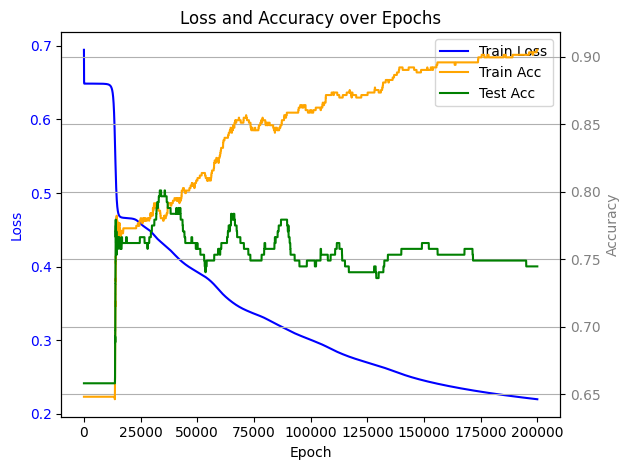


Minimum loss: 0.219872
Maximum train accuracy: 0.9050
Maximum test accuracy: 0.8009

=== Training Model 7/14 ===
Parameters: {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16, 'output_size': 1, 'lr': 0.05, 'activation_hidden': 'sigmoid', 'l2_lambda': 0.001}
Epoch 0: Loss = 0.696031 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.648095 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.465902 | Train Acc = 0.7765 | Test Acc = 0.7706
Epoch 30000: Loss = 0.464603 | Train Acc = 0.7803 | Test Acc = 0.7662
Epoch 40000: Loss = 0.461891 | Train Acc = 0.7784 | Test Acc = 0.7662
Epoch 50000: Loss = 0.457566 | Train Acc = 0.7765 | Test Acc = 0.7749
Epoch 60000: Loss = 0.446592 | Train Acc = 0.7858 | Test Acc = 0.7792
Epoch 70000: Loss = 0.436311 | Train Acc = 0.7840 | Test Acc = 0.7835
Epoch 80000: Loss = 0.430333 | Train Acc = 0.7877 | Test Acc = 0.7922
Epoch 90000: Loss = 0.421797 | Train Acc = 0.7877 | Test Acc = 0.7792
Epoch 100000: Loss = 0.398913 | Train 

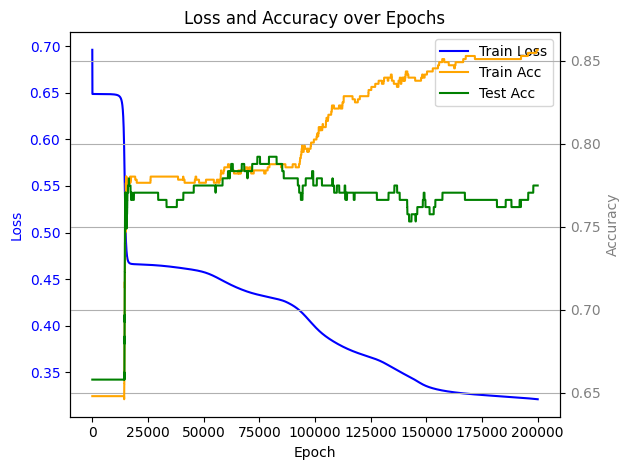


Minimum loss: 0.321132
Maximum train accuracy: 0.8566
Maximum test accuracy: 0.7922

=== Training Model 8/14 ===
Parameters: {'input_size': 8, 'hidden1_size': 64, 'hidden2_size': 32, 'output_size': 1, 'lr': 0.05, 'activation_hidden': 'sigmoid', 'l2_lambda': 0.0}
Epoch 0: Loss = 0.699194 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.642241 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.465023 | Train Acc = 0.7709 | Test Acc = 0.7706
Epoch 30000: Loss = 0.461395 | Train Acc = 0.7765 | Test Acc = 0.7706
Epoch 40000: Loss = 0.451469 | Train Acc = 0.7784 | Test Acc = 0.7706
Epoch 50000: Loss = 0.430983 | Train Acc = 0.7896 | Test Acc = 0.7879
Epoch 60000: Loss = 0.410566 | Train Acc = 0.7970 | Test Acc = 0.7965
Epoch 70000: Loss = 0.369929 | Train Acc = 0.8343 | Test Acc = 0.7706
Epoch 80000: Loss = 0.330906 | Train Acc = 0.8566 | Test Acc = 0.7662
Epoch 90000: Loss = 0.273883 | Train Acc = 0.8957 | Test Acc = 0.7662
Epoch 100000: Loss = 0.229710 | Train Ac

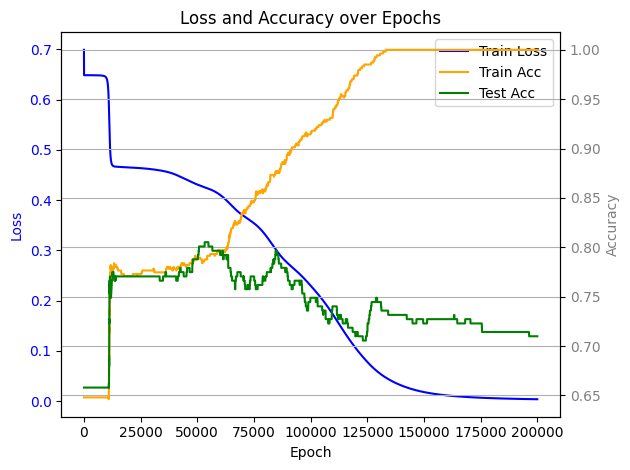


Minimum loss: 0.003496
Maximum train accuracy: 1.0000
Maximum test accuracy: 0.8052

=== Training Model 9/14 ===
Parameters: {'input_size': 8, 'hidden1_size': 8, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.005, 'activation_hidden': 'tanh', 'l2_lambda': 0.0}
Epoch 0: Loss = 0.693147 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.648645 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.648628 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 30000: Loss = 0.648161 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 40000: Loss = 0.468161 | Train Acc = 0.7747 | Test Acc = 0.7619
Epoch 50000: Loss = 0.465999 | Train Acc = 0.7728 | Test Acc = 0.7619
Epoch 60000: Loss = 0.455534 | Train Acc = 0.7784 | Test Acc = 0.7662
Epoch 70000: Loss = 0.438663 | Train Acc = 0.7914 | Test Acc = 0.7922
Epoch 80000: Loss = 0.427074 | Train Acc = 0.7877 | Test Acc = 0.7965
Epoch 90000: Loss = 0.412060 | Train Acc = 0.7933 | Test Acc = 0.7835
Epoch 100000: Loss = 0.389751 | Train Acc = 

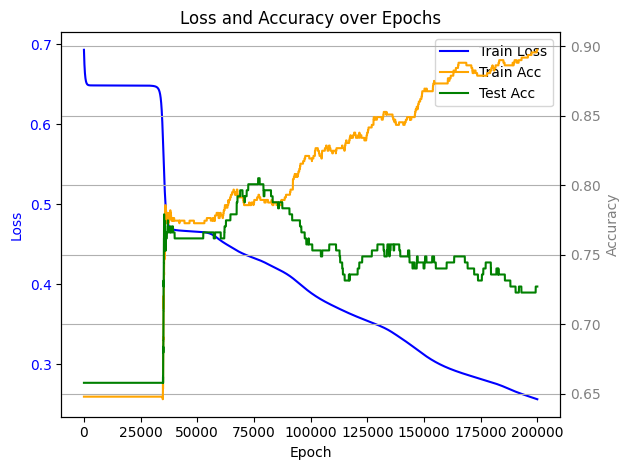


Minimum loss: 0.256556
Maximum train accuracy: 0.8976
Maximum test accuracy: 0.8052

=== Training Model 10/14 ===
Parameters: {'input_size': 8, 'hidden1_size': 8, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'tanh', 'l2_lambda': 0.0}
Epoch 0: Loss = 0.693148 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.647984 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.464842 | Train Acc = 0.7728 | Test Acc = 0.7662
Epoch 30000: Loss = 0.440829 | Train Acc = 0.7877 | Test Acc = 0.7922
Epoch 40000: Loss = 0.407997 | Train Acc = 0.8063 | Test Acc = 0.7706
Epoch 50000: Loss = 0.354786 | Train Acc = 0.8305 | Test Acc = 0.7662
Epoch 60000: Loss = 0.323073 | Train Acc = 0.8529 | Test Acc = 0.7229
Epoch 70000: Loss = 0.290620 | Train Acc = 0.8734 | Test Acc = 0.7316
Epoch 80000: Loss = 0.270640 | Train Acc = 0.8845 | Test Acc = 0.7229
Epoch 90000: Loss = 0.259777 | Train Acc = 0.8808 | Test Acc = 0.7100
Epoch 100000: Loss = 0.249262 | Train Acc = 

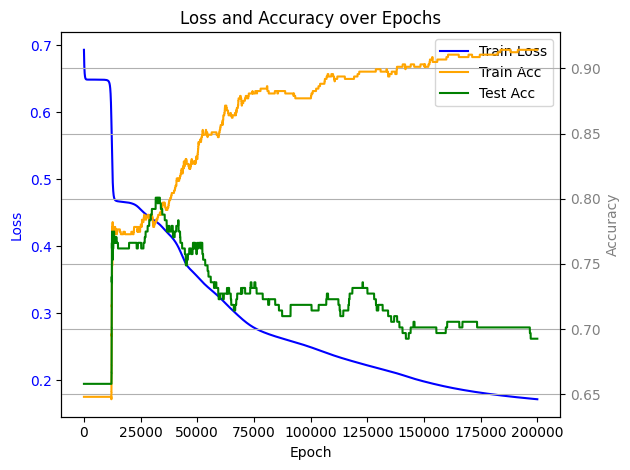


Minimum loss: 0.171553
Maximum train accuracy: 0.9143
Maximum test accuracy: 0.8009

=== Training Model 11/14 ===
Parameters: {'input_size': 8, 'hidden1_size': 8, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.1, 'activation_hidden': 'tanh', 'l2_lambda': 0.0}
Epoch 0: Loss = 0.693147 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.261568 | Train Acc = 0.8883 | Test Acc = 0.7576
Epoch 20000: Loss = 0.154240 | Train Acc = 0.9236 | Test Acc = 0.7013
Epoch 30000: Loss = 0.178384 | Train Acc = 0.9125 | Test Acc = 0.7100
Epoch 40000: Loss = 0.107746 | Train Acc = 0.9516 | Test Acc = 0.7273
Epoch 50000: Loss = 0.095689 | Train Acc = 0.9534 | Test Acc = 0.7186
Epoch 60000: Loss = 0.088734 | Train Acc = 0.9553 | Test Acc = 0.7229
Epoch 70000: Loss = 0.085417 | Train Acc = 0.9553 | Test Acc = 0.7273
Epoch 80000: Loss = 0.082247 | Train Acc = 0.9590 | Test Acc = 0.7186
Epoch 90000: Loss = 0.078935 | Train Acc = 0.9609 | Test Acc = 0.7100
Epoch 100000: Loss = 0.076838 | Train Acc = 0

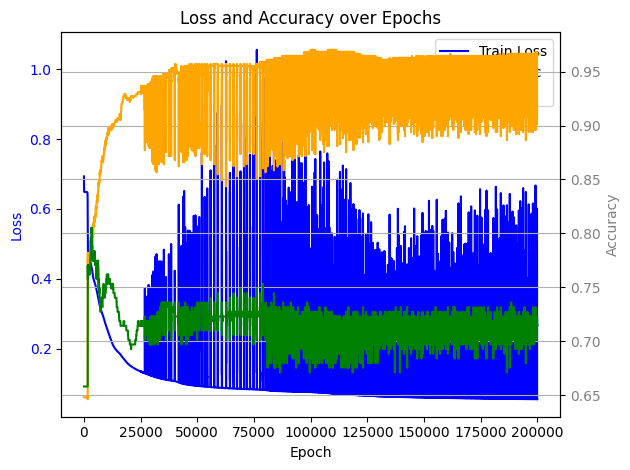


Minimum loss: 0.056095
Maximum train accuracy: 0.9702
Maximum test accuracy: 0.8052

=== Training Model 12/14 ===
Parameters: {'input_size': 8, 'hidden1_size': 8, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.0}
Epoch 0: Loss = 0.693146 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.648644 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.648583 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 30000: Loss = 0.448120 | Train Acc = 0.7840 | Test Acc = 0.7749
Epoch 40000: Loss = 0.419640 | Train Acc = 0.8063 | Test Acc = 0.7835
Epoch 50000: Loss = 0.393518 | Train Acc = 0.8231 | Test Acc = 0.7619
Epoch 60000: Loss = 0.377338 | Train Acc = 0.8194 | Test Acc = 0.7835
Epoch 70000: Loss = 0.369698 | Train Acc = 0.8212 | Test Acc = 0.7792
Epoch 80000: Loss = 0.367458 | Train Acc = 0.8231 | Test Acc = 0.7835
Epoch 90000: Loss = 0.364166 | Train Acc = 0.8343 | Test Acc = 0.7792
Epoch 100000: Loss = 0.363278 | Train Acc = 

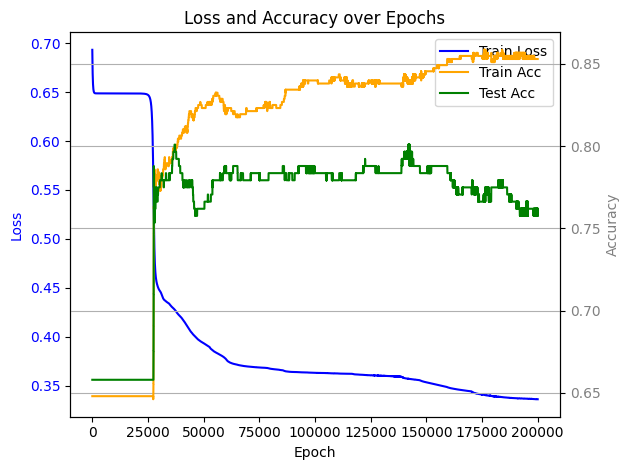


Minimum loss: 0.336293
Maximum train accuracy: 0.8585
Maximum test accuracy: 0.8009

=== Training Model 13/14 ===
Parameters: {'input_size': 8, 'hidden1_size': 8, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'sigmoid', 'l2_lambda': 0.0}
Epoch 0: Loss = 0.692124 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.648637 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.648603 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 30000: Loss = 0.648476 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 40000: Loss = 0.647863 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 50000: Loss = 0.641950 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 60000: Loss = 0.513109 | Train Acc = 0.7616 | Test Acc = 0.7619
Epoch 70000: Loss = 0.467701 | Train Acc = 0.7672 | Test Acc = 0.7576
Epoch 80000: Loss = 0.466200 | Train Acc = 0.7728 | Test Acc = 0.7662
Epoch 90000: Loss = 0.464839 | Train Acc = 0.7728 | Test Acc = 0.7662
Epoch 100000: Loss = 0.459596 | Train Acc

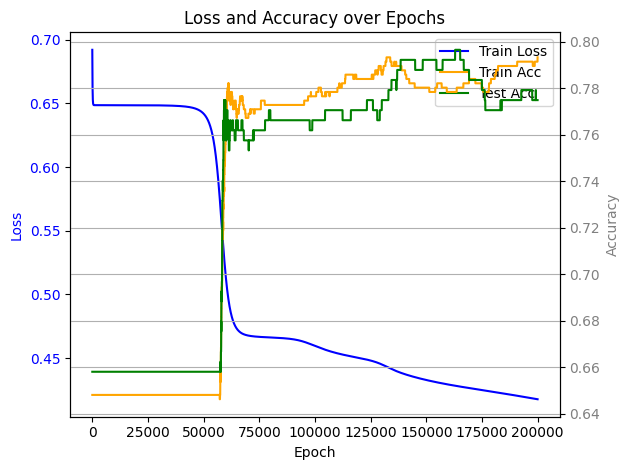


Minimum loss: 0.417674
Maximum train accuracy: 0.7933
Maximum test accuracy: 0.7965

=== Training Model 14/14 ===
Parameters: {'input_size': 8, 'hidden1_size': 8, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'tanh', 'l2_lambda': 0.0}
Epoch 0: Loss = 0.693148 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.648538 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.465811 | Train Acc = 0.7709 | Test Acc = 0.7619
Epoch 30000: Loss = 0.440255 | Train Acc = 0.7914 | Test Acc = 0.7965
Epoch 40000: Loss = 0.423435 | Train Acc = 0.7877 | Test Acc = 0.7792
Epoch 50000: Loss = 0.388502 | Train Acc = 0.8175 | Test Acc = 0.7792
Epoch 60000: Loss = 0.360617 | Train Acc = 0.8250 | Test Acc = 0.7749
Epoch 70000: Loss = 0.323010 | Train Acc = 0.8510 | Test Acc = 0.7706
Epoch 80000: Loss = 0.299338 | Train Acc = 0.8603 | Test Acc = 0.7662
Epoch 90000: Loss = 0.271622 | Train Acc = 0.8771 | Test Acc = 0.7532
Epoch 100000: Loss = 0.257024 | Train Acc = 

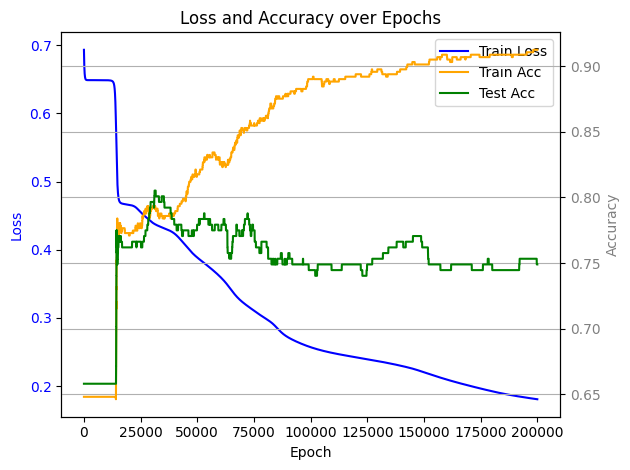


Minimum loss: 0.180679
Maximum train accuracy: 0.9125
Maximum test accuracy: 0.8052


In [37]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def train_model(model_params, X_train, y_train, 
                X_test=None, y_test=None,
                max_epochs=300000, 
                tolerance=1e-5, 
                patience=10000, 
                print_every=100):
    
    # Modell instanziieren
    model = NeuralNetwork(
        input_size=model_params['input_size'],
        hidden1_size=model_params['hidden1_size'],
        hidden2_size=model_params['hidden2_size'],
        output_size=model_params['output_size'],
        lr=model_params['lr'],
        activation_hidden=model_params['activation_hidden'],
        l2_lambda=model_params['l2_lambda']
    )
    
    losses = []
    train_accuracies = []   # neu
    test_accuracies = []
    best_loss = float('inf')
    no_improvement = 0

    for epoch in range(max_epochs):
        loss = model.train(X_train, y_train)
        losses.append(loss)

        # Train-Accuracy berechnen
        y_pred_train = model.predict(X_train)
        y_pred_train_bin = (y_pred_train > 0.5).astype(int)
        acc_train = accuracy_score(y_train, y_pred_train_bin)
        train_accuracies.append(acc_train)

        # Test-Accuracy (falls verfügbar)
        if X_test is not None and y_test is not None:
            y_pred_test = model.predict(X_test)
            y_pred_test_bin = (y_pred_test > 0.5).astype(int)
            acc_test = accuracy_score(y_test, y_pred_test_bin)
            test_accuracies.append(acc_test)

        if print_every and epoch % print_every == 0:
            print(f"Epoch {epoch}: Loss = {loss:.6f} | Train Acc = {acc_train:.4f}", end='')
            if X_test is not None:
                print(f" | Test Acc = {acc_test:.4f}")
            else:
                print()

        # Early stopping
        if best_loss - loss > tolerance:
            best_loss = loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print(f"\nStopped after epoch {epoch}. No improvement for {patience} epochs.")
            break

    # Plot Loss und Accuracies
    fig, ax1 = plt.subplots()
    ax1.plot(losses, label="Train Loss", color='blue')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(train_accuracies, label="Train Acc", color='orange')
    if test_accuracies:
        ax2.plot(test_accuracies, label="Test Acc", color='green')
    ax2.set_ylabel("Accuracy", color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')

    # Legende zusammenführen
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

    plt.title("Loss and Accuracy over Epochs")
    fig.tight_layout()
    plt.grid(True)
    plt.show()

    print(f"\nMinimum loss: {min(losses):.6f}")
    print(f"Maximum train accuracy: {max(train_accuracies):.4f}")
    if test_accuracies:
        print(f"Maximum test accuracy: {max(test_accuracies):.4f}")
    
    return losses, train_accuracies, test_accuracies




# Diabetes Dataset:
parameter_grid = [
    # Regularization - Comparison
    {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16,  'output_size': 1, 'lr': 0.05,  'activation_hidden': 'sigmoid', 'l2_lambda': 0.0},
    {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16,  'output_size': 1, 'lr': 0.05,  'activation_hidden': 'sigmoid', 'l2_lambda': 0.001},
    {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16,  'output_size': 1, 'lr': 0.05,  'activation_hidden': 'sigmoid', 'l2_lambda': 0.003},
    
    # neurons
    {'input_size': 8, 'hidden1_size': 4, 'hidden2_size': 2, 'output_size': 1, 'lr': 0.05, 'activation_hidden': 'sigmoid', 'l2_lambda': 0.00}, # rule of thumb: 2/3 of input size
    {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.05, 'activation_hidden': 'sigmoid', 'l2_lambda': 0.00}, 
    {'input_size': 8, 'hidden1_size': 8, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.05, 'activation_hidden': 'sigmoid', 'l2_lambda': 0.00},
    {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16, 'output_size': 1, 'lr': 0.05, 'activation_hidden': 'sigmoid', 'l2_lambda': 0.001},
    {'input_size': 8, 'hidden1_size': 64, 'hidden2_size': 32, 'output_size': 1, 'lr': 0.05, 'activation_hidden': 'sigmoid', 'l2_lambda': 0.00},
       
    # Learning rates - Separate functiom
    {'input_size': 8, 'hidden1_size': 8, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.005, 'activation_hidden': 'tanh', 'l2_lambda': 0.00}, 
    {'input_size': 8, 'hidden1_size': 8, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'tanh', 'l2_lambda': 0.00}, 
    {'input_size': 8, 'hidden1_size': 8, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.1, 'activation_hidden': 'tanh', 'l2_lambda': 0.00}, 

    # Activation Functions
    {'input_size': 8, 'hidden1_size': 8, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.0},
    {'input_size': 8, 'hidden1_size': 8, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'sigmoid', 'l2_lambda': 0.0},
    {'input_size': 8, 'hidden1_size': 8, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'tanh', 'l2_lambda': 0.0}
]

results = []

for i, params in enumerate(parameter_grid):
    print(f"\n=== Training Model {i+1}/{len(parameter_grid)} ===")
    print(f"Parameters: {params}")

    losses, train_accuracies, test_accuracies = train_model(
        params,
        X_train, y_train,
        X_test=X_test, y_test=y_test,
        max_epochs=200000,
        patience=200000,
        print_every=10000
)
    
    results.append({
        'params': params,
        'min_loss': min(losses),
        'max_accuracy': max(test_accuracies) if test_accuracies else None
    })



=== Training Model 1/5 ===
Parameters: {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.001, 'activation_hidden': 'tanh', 'l2_lambda': 0.0}
Epoch 0: Loss = 0.693143 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.649032 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.648643 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 30000: Loss = 0.648635 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 40000: Loss = 0.648628 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 50000: Loss = 0.648617 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 60000: Loss = 0.648596 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 70000: Loss = 0.648552 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 80000: Loss = 0.648447 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 90000: Loss = 0.648117 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 100000: Loss = 0.646467 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 110000: Loss = 0.625133 | Train Acc = 0.6480 | Test A

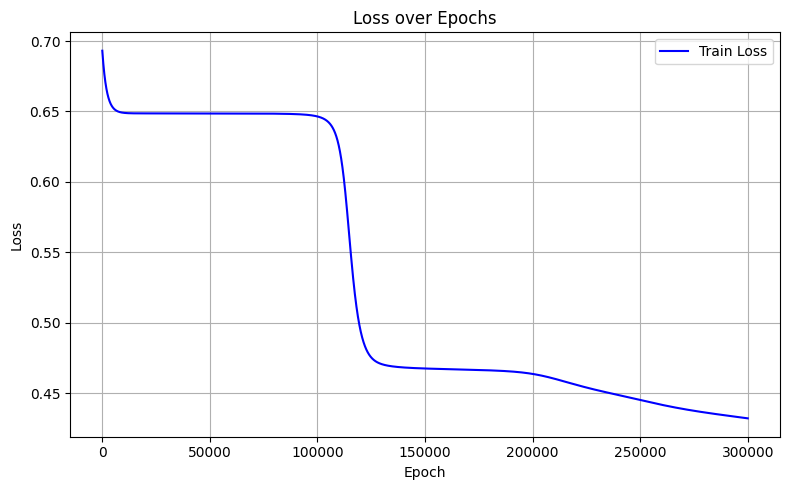


Minimum loss: 0.432118

=== Training Model 2/5 ===
Parameters: {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.005, 'activation_hidden': 'tanh', 'l2_lambda': 0.0}
Epoch 0: Loss = 0.693149 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.648649 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.648648 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 30000: Loss = 0.648647 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 40000: Loss = 0.648641 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 50000: Loss = 0.648594 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 60000: Loss = 0.623609 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 70000: Loss = 0.466412 | Train Acc = 0.7728 | Test Acc = 0.7619
Epoch 80000: Loss = 0.460047 | Train Acc = 0.7765 | Test Acc = 0.7662
Epoch 90000: Loss = 0.445584 | Train Acc = 0.7821 | Test Acc = 0.7922
Epoch 100000: Loss = 0.430328 | Train Acc = 0.7877 | Test Acc = 0.8009
Epoch 110000: Loss = 0.409098 | Tra

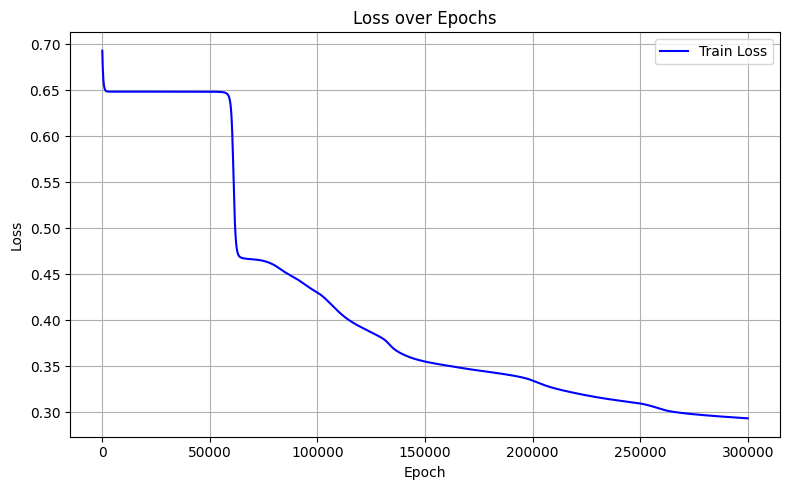


Minimum loss: 0.293590

=== Training Model 3/5 ===
Parameters: {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'tanh', 'l2_lambda': 0.0}
Epoch 0: Loss = 0.693143 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.641496 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 20000: Loss = 0.465238 | Train Acc = 0.7728 | Test Acc = 0.7619
Epoch 30000: Loss = 0.441322 | Train Acc = 0.7914 | Test Acc = 0.7965
Epoch 40000: Loss = 0.412629 | Train Acc = 0.8026 | Test Acc = 0.7706
Epoch 50000: Loss = 0.368181 | Train Acc = 0.8250 | Test Acc = 0.7749
Epoch 60000: Loss = 0.351645 | Train Acc = 0.8305 | Test Acc = 0.7619
Epoch 70000: Loss = 0.341235 | Train Acc = 0.8436 | Test Acc = 0.7792
Epoch 80000: Loss = 0.327712 | Train Acc = 0.8510 | Test Acc = 0.7749
Epoch 90000: Loss = 0.315480 | Train Acc = 0.8566 | Test Acc = 0.7749
Epoch 100000: Loss = 0.308825 | Train Acc = 0.8585 | Test Acc = 0.7706
Epoch 110000: Loss = 0.303626 | Trai

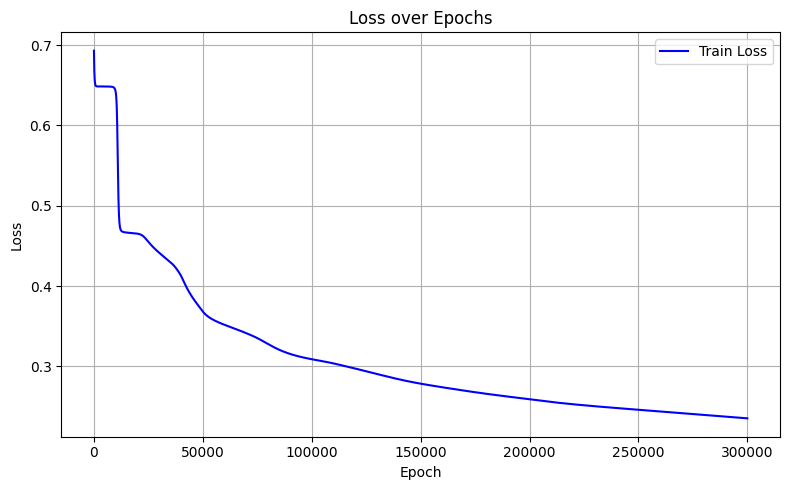


Minimum loss: 0.235202

=== Training Model 4/5 ===
Parameters: {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.05, 'activation_hidden': 'tanh', 'l2_lambda': 0.0}
Epoch 0: Loss = 0.693147 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.427258 | Train Acc = 0.7821 | Test Acc = 0.7662
Epoch 20000: Loss = 0.356930 | Train Acc = 0.8175 | Test Acc = 0.7576
Epoch 30000: Loss = 0.308482 | Train Acc = 0.8510 | Test Acc = 0.7316
Epoch 40000: Loss = 0.288440 | Train Acc = 0.8622 | Test Acc = 0.7229
Epoch 50000: Loss = 0.267304 | Train Acc = 0.8659 | Test Acc = 0.7100
Epoch 60000: Loss = 0.251751 | Train Acc = 0.8734 | Test Acc = 0.7013
Epoch 70000: Loss = 0.238033 | Train Acc = 0.8734 | Test Acc = 0.6883
Epoch 80000: Loss = 0.228667 | Train Acc = 0.8845 | Test Acc = 0.6797
Epoch 90000: Loss = 0.223194 | Train Acc = 0.8845 | Test Acc = 0.6883
Epoch 100000: Loss = 0.217560 | Train Acc = 0.8883 | Test Acc = 0.6926
Epoch 110000: Loss = 0.208786 | Trai

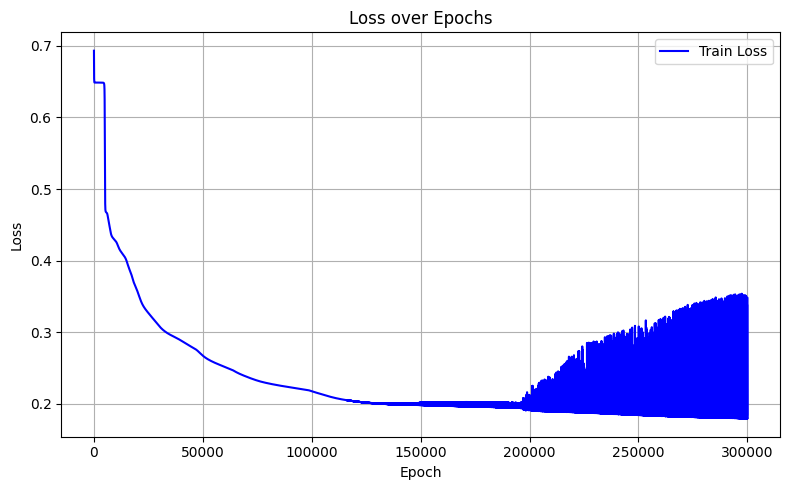


Minimum loss: 0.179820

=== Training Model 5/5 ===
Parameters: {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.1, 'activation_hidden': 'tanh', 'l2_lambda': 0.0}
Epoch 0: Loss = 0.693147 | Train Acc = 0.6480 | Test Acc = 0.6580
Epoch 10000: Loss = 0.306829 | Train Acc = 0.8641 | Test Acc = 0.7273
Epoch 20000: Loss = 0.251959 | Train Acc = 0.8808 | Test Acc = 0.7229
Epoch 30000: Loss = 0.233687 | Train Acc = 0.8883 | Test Acc = 0.7273
Epoch 40000: Loss = 0.224137 | Train Acc = 0.8920 | Test Acc = 0.7273
Epoch 50000: Loss = 0.204900 | Train Acc = 0.8976 | Test Acc = 0.7100
Epoch 60000: Loss = 0.195534 | Train Acc = 0.9013 | Test Acc = 0.7143
Epoch 70000: Loss = 0.190209 | Train Acc = 0.9050 | Test Acc = 0.7100
Epoch 80000: Loss = 0.186563 | Train Acc = 0.9032 | Test Acc = 0.7143
Epoch 90000: Loss = 0.189509 | Train Acc = 0.9088 | Test Acc = 0.7056
Epoch 100000: Loss = 0.181897 | Train Acc = 0.9143 | Test Acc = 0.7100
Epoch 110000: Loss = 0.180110 | Train

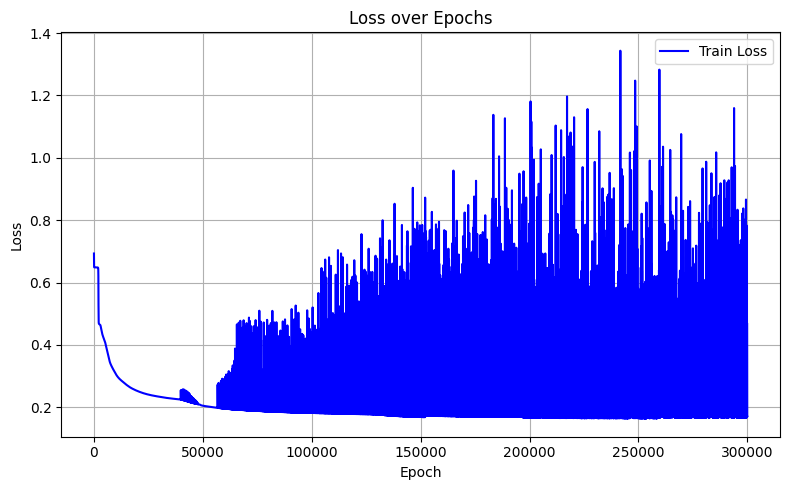


Minimum loss: 0.164392


In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def train_model(model_params, X_train, y_train, 
                X_test=None, y_test=None,
                max_epochs=300000, 
                tolerance=1e-5, 
                patience=10000, 
                print_every=100):
    
    # Modell instanziieren
    model = NeuralNetwork(
        input_size=model_params['input_size'],
        hidden1_size=model_params['hidden1_size'],
        hidden2_size=model_params['hidden2_size'],
        output_size=model_params['output_size'],
        lr=model_params['lr'],
        activation_hidden=model_params['activation_hidden'],
        l2_lambda=model_params['l2_lambda']
    )
    
    losses = []
    best_loss = float('inf')
    no_improvement = 0

    for epoch in range(max_epochs):
        loss = model.train(X_train, y_train)
        losses.append(loss)

        # Optional: Accuracy für Konsole (wird nicht geplottet)
        if print_every and epoch % print_every == 0:
            y_pred_train = model.predict(X_train)
            y_pred_train_bin = (y_pred_train > 0.5).astype(int)
            acc_train = accuracy_score(y_train, y_pred_train_bin)

            if X_test is not None:
                y_pred_test = model.predict(X_test)
                y_pred_test_bin = (y_pred_test > 0.5).astype(int)
                acc_test = accuracy_score(y_test, y_pred_test_bin)
                print(f"Epoch {epoch}: Loss = {loss:.6f} | Train Acc = {acc_train:.4f} | Test Acc = {acc_test:.4f}")
            else:
                print(f"Epoch {epoch}: Loss = {loss:.6f} | Train Acc = {acc_train:.4f}")

        # Early stopping
        if best_loss - loss > tolerance:
            best_loss = loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print(f"\nStopped after epoch {epoch}. No improvement for {patience} epochs.")
            break

    # Plot nur für Loss
    plt.figure(figsize=(8, 5))
    plt.plot(losses, label="Train Loss", color='blue')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"\nMinimum loss: {min(losses):.6f}")
    
    return losses, None, None


# Parameter Grid
parameter_grid = [
    {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.001, 'activation_hidden': 'tanh', 'l2_lambda': 0.00}, 
    {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.005, 'activation_hidden': 'tanh', 'l2_lambda': 0.00}, 
    {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.01, 'activation_hidden': 'tanh', 'l2_lambda': 0.00}, 
    {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.05, 'activation_hidden': 'tanh', 'l2_lambda': 0.00},
    {'input_size': 8, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 1, 'lr': 0.1, 'activation_hidden': 'tanh', 'l2_lambda': 0.00}
]

results = []

for i, params in enumerate(parameter_grid):
    #print(f"\n=== Training Model {i+1}/{len(parameter_grid)} ===")
    #print(f"Parameters: {params}")

    losses, _, _ = train_model(
        params,
        X_train, y_train,
        X_test=X_test, y_test=y_test,
        max_epochs=500000,
        patience=200000,
        print_every=10000
    )
    
    results.append({
        'params': params,
        'min_loss': min(losses)
    })


## Select a final Network

In [44]:
# Modell instanziieren
model_final = NeuralNetwork(**params)

max_epochs       = 200000
target_test_acc  = 0.80 
print_every      = 10000

losses, train_accs, test_accs = [], [], []

for epoch in range(max_epochs):
    # trainging
    loss = model_final.train(X_train, y_train)
    losses.append(loss)

    # accuray train
    y_hat_train = (model_final.predict(X_train) > 0.5).astype(int)
    acc_train   = accuracy_score(y_train, y_hat_train)
    train_accs.append(acc_train)

    #accuracy test
    y_hat_test = (model_final.predict(X_test) > 0.5).astype(int)
    acc_test   = accuracy_score(y_test, y_hat_test)
    test_accs.append(acc_test)

    # print out progress
    if epoch % print_every == 0:
        print(f"Epoch {epoch:7d} --- loss={loss:.6f} | "
              f"train_acc={acc_train:.4f} | test_acc={acc_test:.4f}")

    # break after target accuracy
    if acc_test >= target_test_acc:
        print(f"\nStopp after {epoch} epochs: "
              f"test_acc {acc_test:.4f} >= {target_test_acc}.")
        break


Epoch       0 --- loss=0.693144 | train_acc=0.6480 | test_acc=0.6580
Epoch   10000 --- loss=0.648356 | train_acc=0.6480 | test_acc=0.6580
Epoch   20000 --- loss=0.464842 | train_acc=0.7709 | test_acc=0.7619
Epoch   30000 --- loss=0.436031 | train_acc=0.7840 | test_acc=0.7965

Stopp after 30490 epochs: test_acc 0.8009 >= 0.8.


## Visualization of the network 

Accuracy: 0.8009


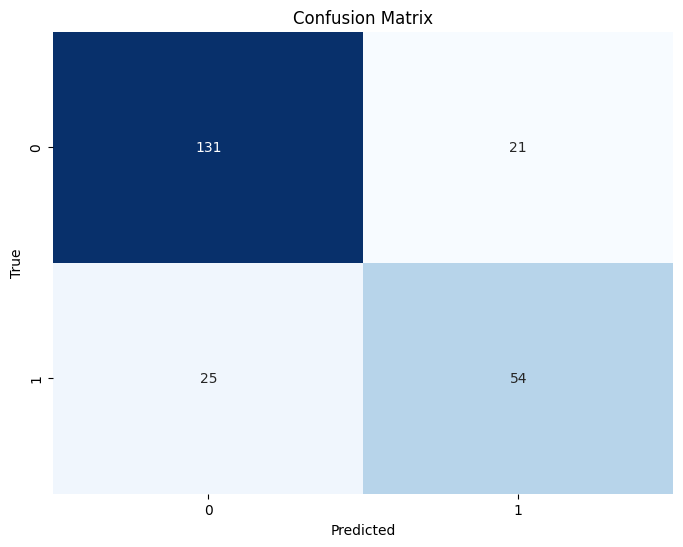

Confusion Matrix:
[[131  21]
 [ 25  54]]


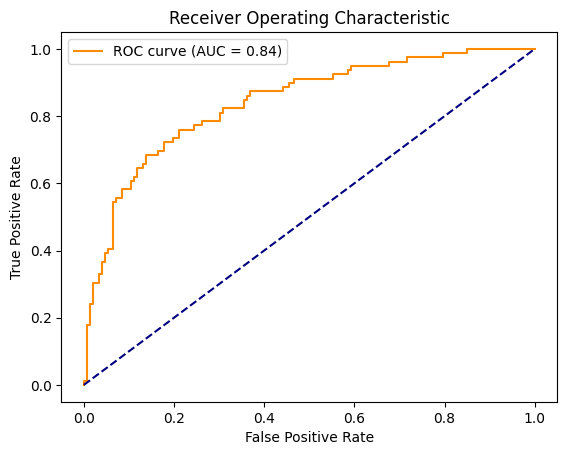

In [47]:
# Predict on test set
y_pred = model_final.predict(X_test)

# Convert predictions to binary with a threshold of 0.5
y_pred_binary = (y_pred >= 0.5).astype(int)
y_test_binary = y_test.astype(int)


# Calculate accuracy
accuracy = np.mean(y_pred_binary == y_test_binary)
print(f"Accuracy: {accuracy:.4f}")

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test_binary, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# print confusion matrix
print("Confusion Matrix:")
print(cm)

# ROC Curve and AUC
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# plot roc curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()


## Model stats 

In [49]:
from pympler import asizeof

def get_model_stats(model):
    import numpy as np

 
    arrays = [model.w0, model.b0, model.w1, model.b1, model.w2, model.b2]
    
    # number of paramters (all weights + biases)
    total_params = sum(arr.size for arr in arrays)

    # RAM
    size_bytes = asizeof.asizeof(model)
    # bytes into MB
    total_MB = size_bytes / (1024 ** 2)

    print(f"Total learnable parameters: {total_params:,}")
    print(f"Total size in RAM: {total_MB:.2f} MB")

    return total_params, total_MB


get_model_stats(model_final)

Total learnable parameters: 113
Total size in RAM: 0.05 MB


(113, 0.05446624755859375)

# 2. PyTorch 

**Sequential Model:**

https://medium.com/writeasilearn/using-sequential-module-to-build-a-neural-network-a34ca3f37203


In [8]:
# Data 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
import torch

# Features: float32
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch  = torch.tensor(X_test, dtype=torch.float32)

# Targets: float32 UND als Spaltenvektor (N, 1)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_torch  = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim


model = nn.Sequential(
    nn.Linear(8, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 1),
    nn.Sigmoid()
)

# binary cross-entropy loss
criterion = nn.BCELoss() 

# Optimizer
#optimizer = optim.Adam(model.parameters(), lr=0.01)
lr = 0.1

# Training loop
epochs = 1000
for epoch in range(epochs):
    model.train()

    # Forward-Pass
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)

    # Zero gradients because PyTorch accumulates gradients
    model.zero_grad()

    # Backward-Pass (clac gradients)
    loss.backward()

    # Update manuelly
    with torch.no_grad():
        for param in model.parameters():
            param -= lr * param.grad

    # print loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.6855
Epoch 100, Loss: 0.4597
Epoch 200, Loss: 0.4314
Epoch 300, Loss: 0.4159
Epoch 400, Loss: 0.4031
Epoch 500, Loss: 0.3918
Epoch 600, Loss: 0.3814
Epoch 700, Loss: 0.3711
Epoch 800, Loss: 0.3601
Epoch 900, Loss: 0.3491


Test Accuracy: 0.7273


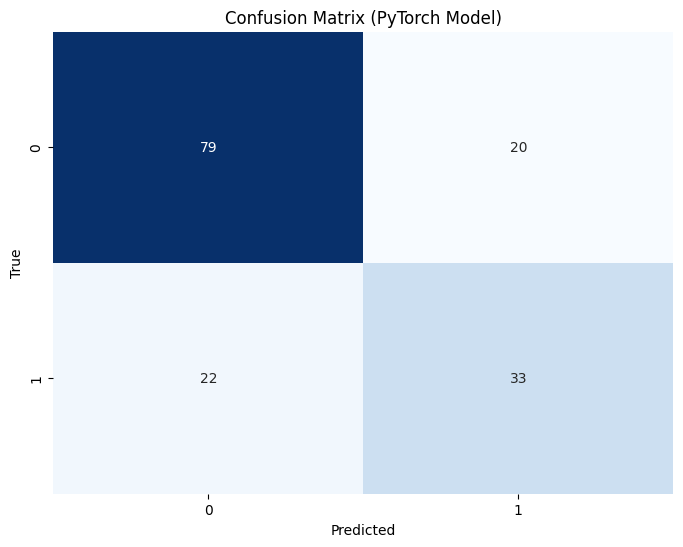

In [10]:
# Predict on test 
outputs_test = model(X_test_torch)
# Convert predictions to binary with a threshold of 0.5
y_pred_test = (outputs_test >= 0.5).float()
# Calculate accuracy
accuracy_test = (y_pred_test == y_test_torch).float().mean()
print(f"Test Accuracy: {accuracy_test:.4f}")
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_test_torch.numpy(), y_pred_test.numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (PyTorch Model)')
plt.show()


# 3. LLM Implementation


Prompt: 
Implement a framework for neural networks (NN). Implement the entire network from scratch, including forward and backward propagation methods

In [83]:
import numpy as np

# Base class for layers
class Layer:
    def forward(self, input):
        raise NotImplementedError
        
    def backward(self, output_gradient, learning_rate):
        raise NotImplementedError

# Dense (fully connected) layer
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(input_size, output_size) * np.sqrt(2. / input_size)
        self.bias = np.zeros((1, output_size))

    def forward(self, input):
        self.input = input
        return np.dot(input, self.weights) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(self.input.T, output_gradient)
        input_gradient = np.dot(output_gradient, self.weights.T)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * np.mean(output_gradient, axis=0, keepdims=True)
        return input_gradient

# Activation functions
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(input)

    def backward(self, output_gradient, learning_rate):
        return self.activation_prime(self.input) * output_gradient

# Specific activation functions
def relu(x):
    return np.maximum(0, x)

def relu_prime(x):
    return (x > 0).astype(float)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    s = sigmoid(x)
    return s * (1 - s)

# Loss function
class MeanSquaredError:
    def loss(self, predicted, actual):
        return np.mean(np.power(predicted - actual, 2))

    def gradient(self, predicted, actual):
        return 2 * (predicted - actual) / actual.size

# Neural network class
class NeuralNetwork2:
    def __init__(self):
        self.layers = []
        self.loss_fn = MeanSquaredError()

    def add(self, layer):
        self.layers.append(layer)

    def predict(self, x):
        output = x
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def train(self, x_train, y_train, epochs, learning_rate):
        for epoch in range(epochs):
            output = self.predict(x_train)
            loss = self.loss_fn.loss(output, y_train)
            grad = self.loss_fn.gradient(output, y_train)
            
            for layer in reversed(self.layers):
                grad = layer.backward(grad, learning_rate)
            
            if (epoch + 1) % 100 == 0 or epoch == 0:
                print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")

Epoch 1, Loss: 0.2930
Epoch 100, Loss: 0.2377
Epoch 200, Loss: 0.2151
Epoch 300, Loss: 0.1953
Epoch 400, Loss: 0.1844
Epoch 500, Loss: 0.1796
Epoch 600, Loss: 0.1758
Epoch 700, Loss: 0.1720
Epoch 800, Loss: 0.1691
Epoch 900, Loss: 0.1671
Epoch 1000, Loss: 0.1654
Accuracy: 0.7150


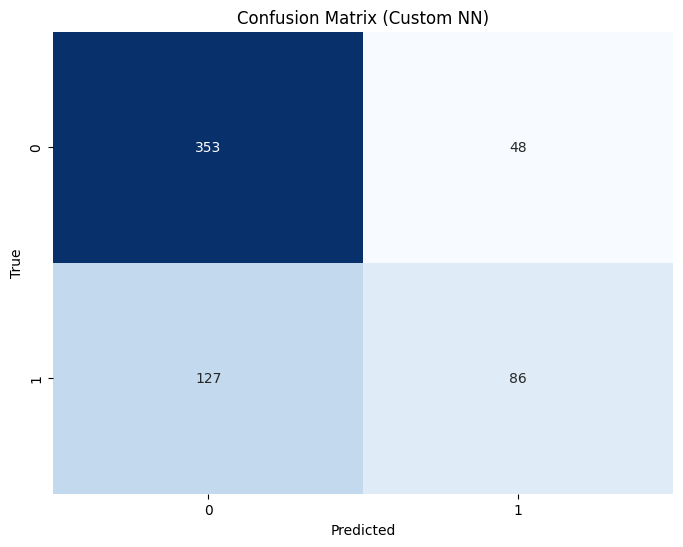

In [84]:
nn = NeuralNetwork2()
nn.add(Dense(8, 4))
nn.add(Activation(relu, relu_prime))
nn.add(Dense(4, 1))
nn.add(Activation(sigmoid, sigmoid_prime))


nn.train(X_train, y_train, epochs=1000, learning_rate=0.1)

# Predictions
preds = nn.predict(X_train)
pred_classes = (preds >= 0.5).astype(int)

true_classes = y_train.reshape(-1, 1)

# Accuracy 
accuracy = np.mean(pred_classes == true_classes)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_nn = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Custom NN)')
plt.show()

